In [1]:
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cvxopt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


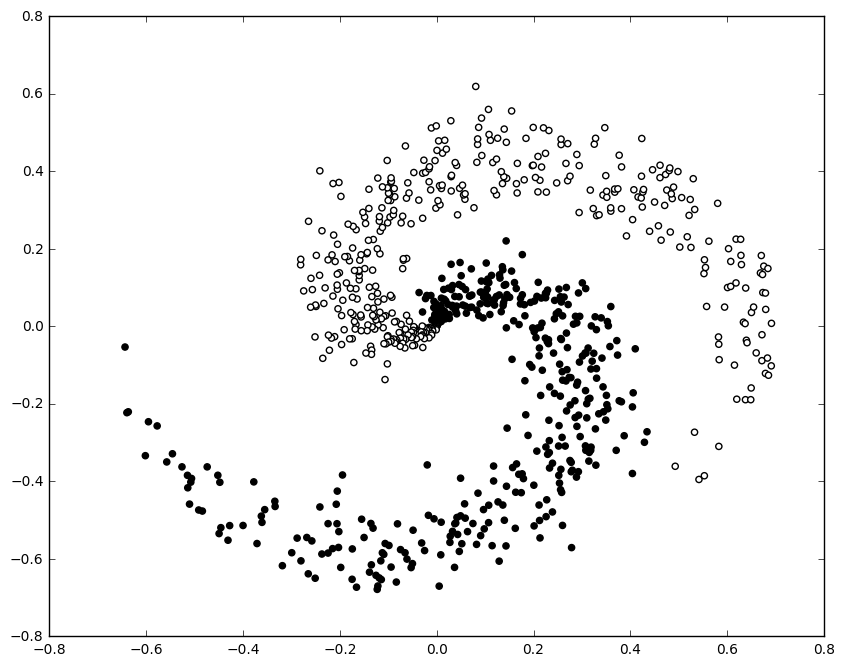

In [2]:
K = 2
N = 400

X = np.zeros((N * K, 2))
y = np.zeros(N * K)

for j in range(K):
    ii = range(N * j, N * (j + 1))
    r = np.linspace(0.0, 0.7, N)
    t = np.linspace(j*4, (j + 1) * 4, N) + np.random.randn(N) * 0.4
    X[ii] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ii] = 2 * j - 1

train_test_split = np.array(random.sample(range(N * K), N))

X_train = X[train_test_split, :]
y_train = y[train_test_split]
    
X_test = X[-train_test_split, :]
y_test = y[-train_test_split]

plt.scatter(X[:, 0], X[:, 1], c = y);

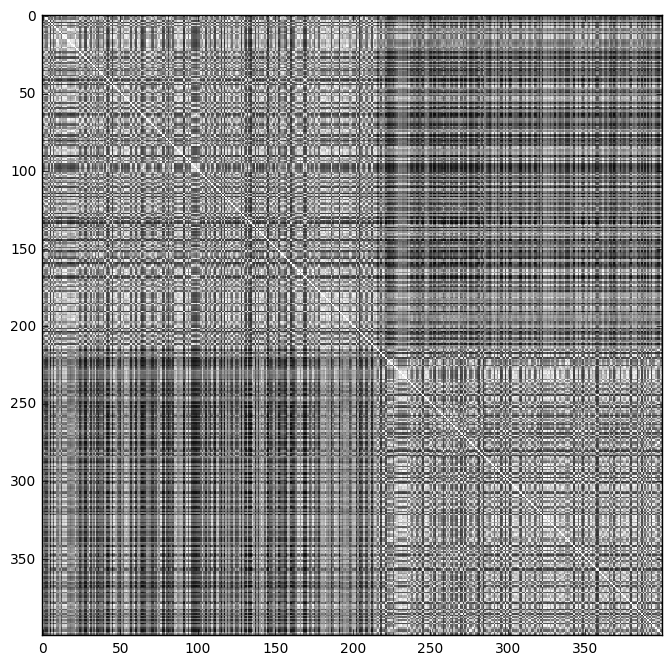

In [3]:
def svm_kernel(X, Y):
    Z = np.zeros((X.shape[0], Y.shape[0]))
    for i in range(X.shape[0]):
        Z[i, :] = np.exp(-np.linalg.norm(X[i] - Y, axis = 1))
    return Z

plt.imshow(svm_kernel(X_train[np.argsort(y_train), :], X_train[np.argsort(y_train), :]));

     pcost       dcost       gap    pres   dres
 0: -4.3869e+01 -1.4300e+02  9e+02  2e+01  2e+00
 1: -6.4205e+01 -1.9502e+02  5e+02  1e+01  9e-01
 2: -1.5848e+02 -3.5254e+02  4e+02  6e+00  6e-01
 3: -2.0535e+02 -3.2133e+02  2e+02  2e+00  2e-01
 4: -2.0165e+02 -3.1759e+02  1e+02  1e-02  1e-03
 5: -2.3270e+02 -2.6707e+02  3e+01  3e-03  3e-04
 6: -2.4316e+02 -2.5513e+02  1e+01  7e-04  7e-05
 7: -2.4762e+02 -2.5110e+02  3e+00  7e-14  6e-14
 8: -2.4906e+02 -2.5010e+02  1e+00  6e-14  6e-14
 9: -2.4960e+02 -2.4983e+02  2e-01  6e-14  7e-14
10: -2.4970e+02 -2.4980e+02  1e-01  1e-13  7e-14
11: -2.4978e+02 -2.4979e+02  6e-03  4e-14  6e-14
12: -2.4979e+02 -2.4979e+02  9e-05  4e-14  7e-14
Optimal solution found.
beta0 = 0.408150071446


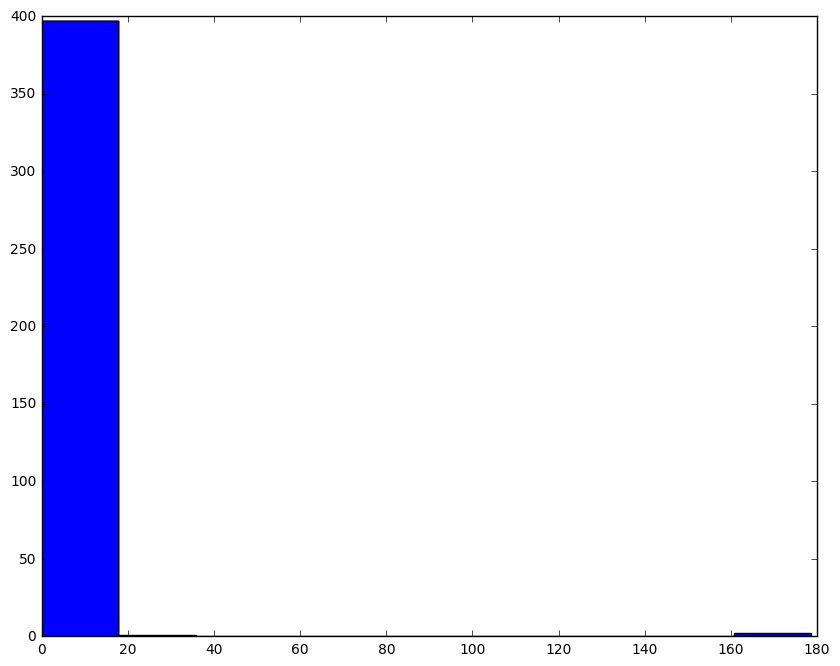

In [4]:
# http://cs229.stanford.edu/notes/cs229-notes3.pdf
# L = sum(alpha) - 1/2 * sum_i(sum_j(alpha_i * alpha_j * y_i * y_j * kernel(x_i, x_j)))
# subject to sum_i(alpha_i * y_i) = 0
#            alpha > 0

# http://cvxopt.org/userguide/coneprog.html#quadratic-programming
# minimize 1/2 * x.T * P * x + q.T * x
# subject to G * x < h
#            A * x = b

def svm_train(X, y):
    N = X.shape[0]

    P = cvxopt.matrix(svm_kernel(X, X) * np.outer(y, y))
    q = cvxopt.matrix(-np.ones(N))
    G = cvxopt.matrix(-1.0 * np.eye(N))
    h = cvxopt.matrix(0.0, (N, 1))
    A = cvxopt.matrix(y, (1, N))
    b = cvxopt.matrix(0.0)

    solution = cvxopt.solvers.qp(P, q, G, h, A, b)
    
    alpha = np.array(solution["x"]).reshape(-1)
    
    beta = np.sum(alpha * y * svm_kernel(X, X).T, axis = 1)
    beta0 = -(np.max(beta[y > 0]) + np.min(beta[y < 0])) / 2.
    
    return (alpha, beta0)

(alpha, beta0) = svm_train(X_train, y_train)

print("beta0 =", beta0)
plt.hist(alpha);

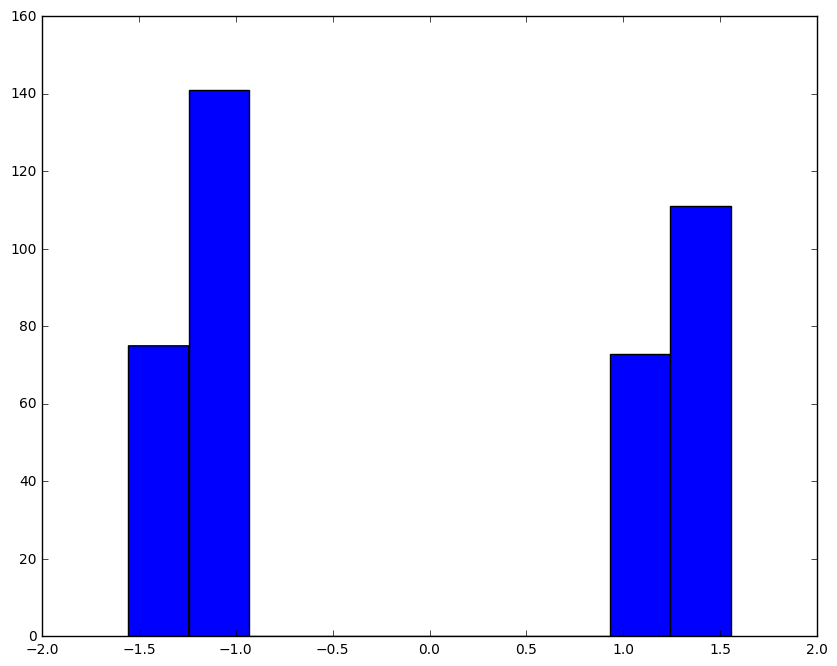

In [5]:
plt.hist(np.sum(alpha * y_train * svm_kernel(X_train, X_train).T, axis = 1) + beta0);

In [6]:
def svm_transform(X): return np.sum(alpha * y_train * svm_kernel(X_train, X).T, axis = 1) + beta0
def svm_predict(X):  return np.sign(svm_transform(X))

print("accuracy on training set =", (svm_predict(X_train) == y_train).mean())
print("accuracy on test set =", (svm_predict(X_test) == y_test).mean())


accuracy on training set = 1.0
accuracy on test set = 1.0


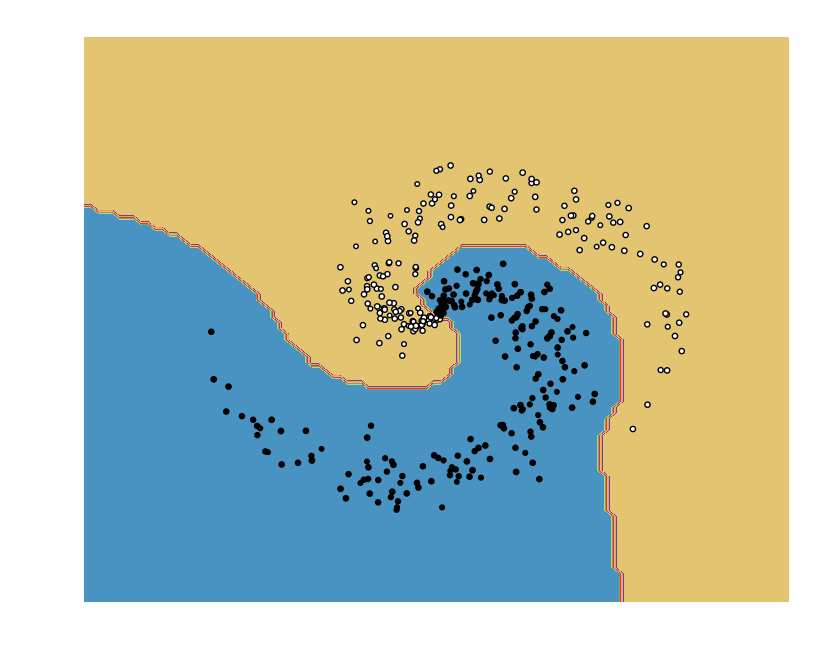

In [7]:
xx, yy = np.meshgrid(np.arange(-1, 1, 0.02), np.arange(-1, 1, 0.02))
X_boundary = np.c_[xx.ravel(), yy.ravel()]
y_transform = svm_transform(X_boundary)
y_predict = svm_predict(X_boundary)

plt.contourf(xx, yy, y_predict.reshape(xx.shape), cmap=plt.cm.Paired)
plt.axis('off')
plt.scatter(X_train[:, 0], X_train[:, 1], c = y_train, s = 10 * np.log2(2 + np.abs(y_transform)));

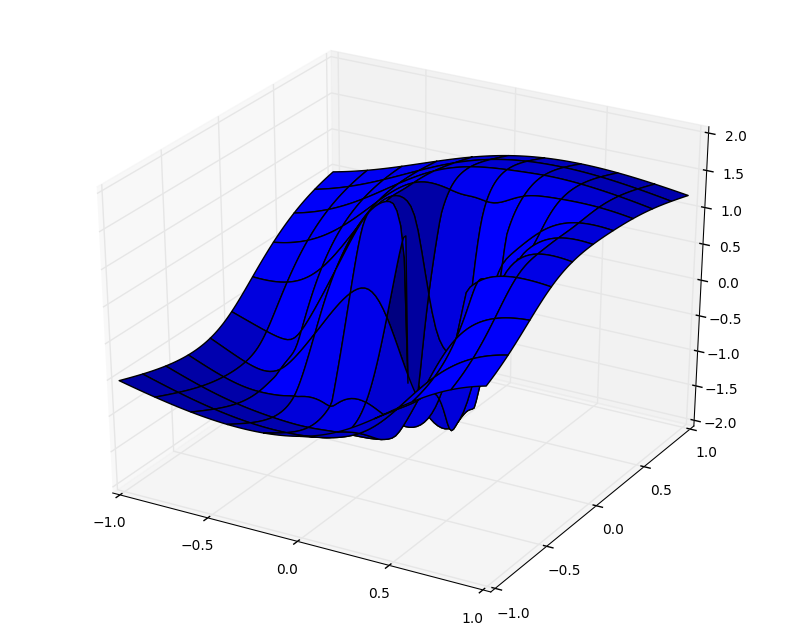

In [8]:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx, yy, y_transform.reshape(xx.shape), color='b');


     pcost       dcost       gap    pres   dres
 0: -3.5588e+02 -8.7055e+02  5e+02  4e-15  2e+00
 1: -6.6563e+02 -8.3806e+02  2e+02  8e-15  1e+00
 2: -1.6637e+03 -2.0033e+03  3e+02  3e-14  1e+00
 3: -2.7427e+03 -3.2961e+03  6e+02  1e-13  1e+00
 4: -9.5524e+03 -1.4612e+04  5e+03  3e-13  4e-01
 5: -9.8451e+03 -1.0350e+04  5e+02  1e-12  1e-02
 6: -9.8636e+03 -9.8887e+03  3e+01  4e-13  5e-04
 7: -9.8664e+03 -9.8683e+03  2e+00  7e-13  3e-05
 8: -9.8668e+03 -9.8668e+03  8e-02  6e-13  1e-06
 9: -9.8668e+03 -9.8668e+03  3e-03  5e-13  1e-08
Optimal solution found.


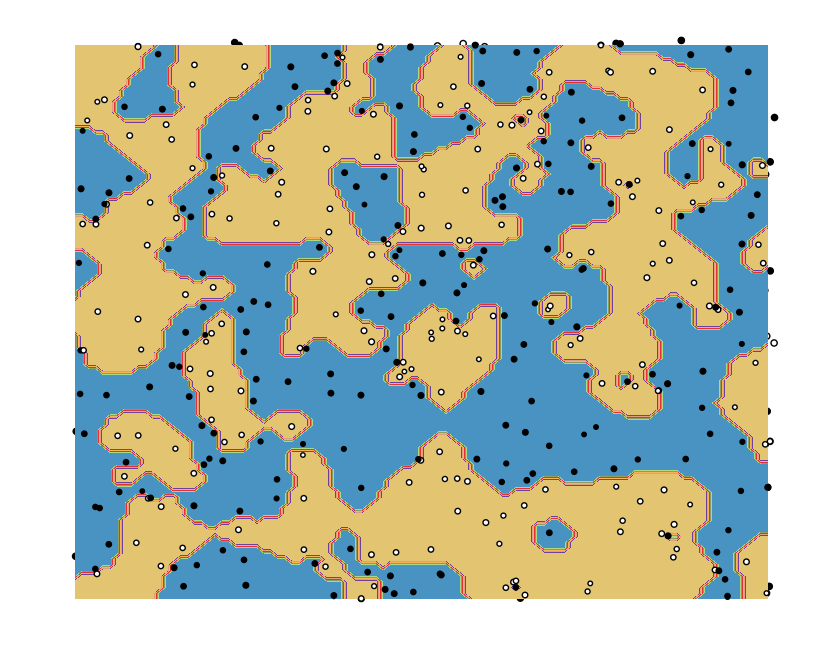

In [9]:
X = np.random.uniform(size = (N * K, 2))
y = np.sign(np.random.uniform(low = -1, size = N * K))

train_test_split = np.array(random.sample(range(N * K), N))

X_train = X[train_test_split, :]
y_train = y[train_test_split]
    
X_test = X[-train_test_split, :]
y_test = y[-train_test_split]

plt.scatter(X[:, 0], X[:, 1], c = y);

(alpha, beta0) = svm_train(X_train, y_train)

xx, yy = np.meshgrid(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01))
X_boundary = np.c_[xx.ravel(), yy.ravel()]
y_transform = svm_transform(X_boundary)
y_predict = svm_predict(X_boundary)

plt.contourf(xx, yy, y_predict.reshape(xx.shape), cmap=plt.cm.Paired)
plt.axis('off')
plt.scatter(X_train[:, 0], X_train[:, 1], c = y_train, s = 10 * np.log2(2 + np.abs(y_transform)));